Problem 4: What is the closest shopping center from your home / work? (5 points)
In the last problem you should find out the closest shopping center from two different locations a) your home and b) work place.

Steps:

Create a txt-file called activity_locations.txt (use same formatting as in Problem 1) with two columns:
id: unique id for each row
addr: address of your work and home (or any two addresses in the Helsinki Region.)
Save the text file into this repository.

- Read those addresses using pandas and geocode the addresses.
- Find out the nearest shopping center to these points using Shapely nearest_points.
- Print out the name of the shopping center that is nearest to a) home and b) work. For example: Shopping center closest to home: REDI.

In [82]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon

#import the geocoding tool
from geopandas.tools import geocode

#import CRS class for crs reprojection
from pyproj import CRS

#for plotting geopandas dataframe and visual inspection
import matplotlib.pyplot as plt

- Read those addresses using pandas and geocode the addresses.

In [83]:
data = pd.read_csv('activity_locations.txt', sep = ';')

print(data.head())

   id                                       addr
0   0          Koirasaarentie 35, 00590 Helsinki
1   1  Gustaf Hällströmin katu 2, 00560 Helsinki


In [84]:
#not using rate limiter due to small amount of geocoding (2 rows)

#geocode addresses using Nominatim api. #nominatim is rate limited to 1 call /second
geo = geocode(data['addr'], provider='nominatim', user_agent='autogis_xx',timeout=4)

#verify geocode works
geo.head()

,geometry,address
0,POINT (25.02474 60.16878),"Koirasaarentie, Hopealaakso, Kruunuvuorenranta..."
1,POINT (24.96289 60.20490),"Unicafe Physicum, 2, Gustaf Hällströmin katu, ..."


- Find out the nearest shopping center to these points using Shapely nearest_points.

In [85]:
#read in the shopping_centers.shp data
shopping_centers = gpd.read_file("shopping_centers.shp")

print(shopping_centers.head())
print(shopping_centers.shape) #7 rows, 5 columns

                                             address  id       name  \
0  Kauppakeskus Itis, 1-7, Itäkatu, Itäkeskus, Va...   0       Itis   
1  Salaattiasema, 14-20, Mannerheimintie, Kluuvi,...   1      Forum   
2  Sports Academy, 11, Piispansilta, Matinkylä, S...   2  Iso-Omena   
3  Lasten kappeli Arkki, 3-9, Leppävaarankatu, Sä...   3      Sello   
4  Stockmann, 3, Vantaanportinkatu, Vantaanportti...   4      Jumbo   

                                             addr  \
0            Itäkatu 1-7, 00930 Helsinki, Finland   
1  Mannerheimintie 14-20, 00100 Helsinki, Finland   
2           Piispansilta 11, 02230 Espoo, Finland   
3       Leppävaarankatu 3-9, 02600 Espoo, Finland   
4               Vantaanportinkatu 3, 01510 Vantaa   

                           geometry  
0  POINT (25504598.602 6677662.109)  
1  POINT (25496573.542 6672878.360)  
2  POINT (25485431.705 6672252.372)  
3  POINT (25489491.076 6678322.265)  
4  POINT (25497943.932 6686656.982)  
(7, 5)


In [86]:
#Check coordinate reference system information (re-project / define if needed)
print(shopping_centers.crs)
print(geo.crs)

epsg:3879
EPSG:4326


In [87]:
#reproject the coordinates in the geometry column  and redefine the .crs definition
geo = geo.to_crs(shopping_centers.crs)
print(geo.crs)
print(type(geo.crs))

epsg:3879
<class 'pyproj.crs.crs.CRS'>


In [88]:
from shapely.ops import nearest_points

def get_nearest_values(row, other_gdf, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    
    return nearest_value

In [89]:
#get the nearest shopping center to the work/home addresses
geo["nearest_location_id"] = geo.apply(get_nearest_values, other_gdf=shopping_centers, point_column="geometry", value_column="id", axis=1)

print(geo.head())

                           geometry  \
0  POINT (25501373.676 6672876.994)   
1  POINT (25497942.152 6676901.898)   

                                             address  nearest_location_id  
0  Koirasaarentie, Hopealaakso, Kruunuvuorenranta...                    5  
1  Unicafe Physicum, 2, Gustaf Hällströmin katu, ...                    6  


In [90]:
#extract nearest_location addresses using the id of the shopping_centers, add to the dataframe
geo["nearest_location_address"] = [shopping_centers.at[ geo.at[0,'nearest_location_id'], 'address' ] ,shopping_centers.at[ geo.at[1,'nearest_location_id'], 'address' ] ]

In [91]:
print(geo.head())

                           geometry  \
0  POINT (25501373.676 6672876.994)   
1  POINT (25497942.152 6676901.898)   

                                             address  nearest_location_id  \
0  Koirasaarentie, Hopealaakso, Kruunuvuorenranta...                    5   
1  Unicafe Physicum, 2, Gustaf Hällströmin katu, ...                    6   

                            nearest_location_address  
0  Yoga Valo, 5, Hermannin rantatie, Verkkosaari,...  
1  Pasilansilta, Keski-Pasila, Pasila, Keskinen s...  


In [92]:
#extract nearest_location points using the id of the shopping_centers, add to the dataframe
geo["nearest_location_geometry"] = [shopping_centers.at[ geo.at[0,'nearest_location_id'], 'geometry' ] ,shopping_centers.at[ geo.at[1,'nearest_location_id'], 'geometry' ] ]

In [93]:
print(geo.head())

                           geometry  \
0  POINT (25501373.676 6672876.994)   
1  POINT (25497942.152 6676901.898)   

                                             address  nearest_location_id  \
0  Koirasaarentie, Hopealaakso, Kruunuvuorenranta...                    5   
1  Unicafe Physicum, 2, Gustaf Hällströmin katu, ...                    6   

                            nearest_location_address  \
0  Yoga Valo, 5, Hermannin rantatie, Verkkosaari,...   
1  Pasilansilta, Keski-Pasila, Pasila, Keskinen s...   

                     nearest_location_geometry  
0  POINT (25498829.27422557 6674970.005298332)  
1  POINT (25496345.00760458 6676150.296155145)  


In [94]:
#extract shopping_center locations that are nearest to the addresses
geo_col = geo.columns
nearest_shopping_center = geo.copy()
nearest_shopping_center.drop( columns =geo_col[0:3], inplace=True, axis =1)

#covert nearest_location_geometry -> geometry to allowing plotting of the points
nearest_shopping_center.rename(columns={"nearest_location_geometry" : "geometry"}, inplace =True)

#verify if crs of the geodataframe is still intact
print(nearest_shopping_center.crs)

print(nearest_shopping_center.head())
    

epsg:3879
                            nearest_location_address  \
0  Yoga Valo, 5, Hermannin rantatie, Verkkosaari,...   
1  Pasilansilta, Keski-Pasila, Pasila, Keskinen s...   

                           geometry  
0  POINT (25498829.274 6674970.005)  
1  POINT (25496345.008 6676150.296)  


<AxesSubplot:>

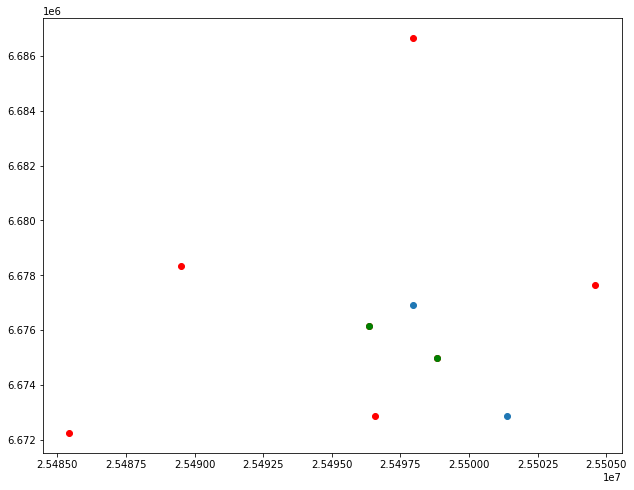

In [95]:
#visual inspection to verify the shopping centers are in fact near the 2 work/home addresses

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(15,8))

# Plot population grid
geo.plot(ax=ax)

# Plot points
shopping_centers.plot(ax=ax, color='red')

# identify nearest shoppping_centers
nearest_shopping_center.plot(color='green', ax=ax)

- Print out the name of the shopping center that is nearest to a) home and b) work. For example: Shopping center closest to home: REDI.

In [98]:
for row in range(0,len(geo)):
    print( "Shopping center, ", geo.at[row,'nearest_location_address'], ", closest to, " , geo.at[row,'address'], ". \n"  )

Shopping center,  Yoga Valo, 5, Hermannin rantatie, Verkkosaari, Kalasatama, Sörnäinen, Helsinki, Helsingin seutukunta, Uusimaa, Etelä-Suomen aluehallintovirasto, Manner-Suomi, 00580, Suomi , closest to,  Koirasaarentie, Hopealaakso, Kruunuvuorenranta, Laajasalo, Helsinki, Helsingin seutukunta, Uusimaa, Etelä-Suomen aluehallintovirasto, Manner-Suomi, 00590, Suomi . 

Shopping center,  Pasilansilta, Keski-Pasila, Pasila, Keskinen suurpiiri, Helsingin seutukunta, Uusimaa, Etelä-Suomen aluehallintovirasto, Manner-Suomi, 00077, Suomi , closest to,  Unicafe Physicum, 2, Gustaf Hällströmin katu, Kumpula, Helsinki, Helsingin seutukunta, Uusimaa, Etelä-Suomen aluehallintovirasto, Manner-Suomi, 00560, Suomi . 

